# Gaze Detection

This document will go over our gaze detection component of the system. This pretty much just means this is how we will figureout where people are looking in images.

## Setup

In [ ]:
# may be necessary for dlib library, in this order (we had that error at first)

#!pip install cmake
#!pip install face_recognition
#!pip install dlib

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/36.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/36.4 MB ? eta -:--:--
   - -------------------------------------- 1.0/36.4 MB 2.8 MB/s eta 0:00:13
   - -------------------------------------- 1.3/36.4 MB 2.1 MB/s eta 0:00:17
   -- ------------------------------------- 1.8/36.4 MB 2.3 MB/s eta 0:00:16
   -- ------------------------------------- 2.6/36.4 MB 2.6 MB/s eta 0:00:14
   --- ------------------------------------ 3.4/36.4 MB 2.8 MB/s eta 0:00:12
   ---- ----------------------------------- 4.2/36.4 MB 3.0 MB/s eta 0:00:11
   ----- ---------------------------------- 5.2/36.4 MB 3.2 MB/s eta 0:00:10
   ------ --------------------------------- 6.3/36.4 MB 3.4 MB/s eta 0:00:09
   ------- -------------------------------- 7.1/36.4 MB 3.5 MB/s eta 0:00:09
   -------- ------------------------------- 8.1/36.4 MB 3.5 MB/s eta 0:00:08
   ---------


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/100.1 MB ? eta -:--:--
     - ------------------------------------- 2.6/100.1 MB 13.8 MB/s eta 0:00:08
     -- ------------------------------------ 7.3/100.1 MB 18.1 MB/s eta 0:00:06
     ---- --------------------------------- 13.1/100.1 MB 21.1 MB/s eta 0:00:05
     ------- ------------------------------ 18.6/100.1 MB 21.8 MB/s eta 0:00:04
     --------- ---------------------------- 26.0/100.1 MB 24.6 MB/s eta 0:00:04
     ------------ ------------------------- 33.0/100.1 MB 25.9 MB/s eta 0:00:03
     ------------- ------------------------ 36.4/100.1 MB 25.5 MB/s eta 0:00:03
     -------------- ----------------------- 39.1/100.1 MB 23.0 MB/s eta 0:00:03
     --------------- ---------------------- 41.9/100.1 MB 22.1 MB/s eta 0:00:03
     ---------------- --------------------- 44.6/100.1 MB 21.7 MB/s eta 0:00:03
     ------------------ ------------------- 48.8/


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import dlib


## Facial Landmarks

Our approach is one that detects facial landmarks, and then just uses the eye regions to decide the gaze direction.

First, we are going to download the facial landmarks model.

In [3]:
print("Beginning gaze detection. Step 1: Setting up facial landmark detection")

# Download facial landmark detector model if needed
landmark_model_path = 'models/shape_predictor_68_face_landmarks.dat'

if not os.path.exists(landmark_model_path):
    print("Downloading facial landmark model...")
    !curl -L -o models/shape_predictor_68_face_landmarks.dat.bz2 http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -d models/shape_predictor_68_face_landmarks.dat.bz2
    print("Download complete!")
else:
    print("Facial landmark model already exists!")

Beginning gaze detection. Step 1: Setting up facial landmark detection
Facial landmark model already exists!


## Face Detector

Now, we're going to import the face detector in

In [4]:
model_file = "models/haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(model_file)

## Eye Extraction

Next, we're going to extract eyes from the faces that are detected. We're going to make a function for that for future usage:

In [5]:
# Initialize the face detector and facial landmark predictor
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')

def get_eyes_from_face(face_image, face_rect=None):
    """
    Extract left and right eye images from a face image
    
    Args:
        face_image: RGB image containing a face
        face_rect: Face rectangle coordinates (optional)
        
    Returns:
        left_eye: Left eye image
        right_eye: Right eye image
        eye_centers: Centers of left and right eyes
    """
    # Convert to grayscale for better detection
    gray = cv2.cvtColor(face_image, cv2.COLOR_RGB2GRAY)
    
    # If face_rect is not provided, detect face
    if face_rect is None:
        faces = face_detector(gray)
        if len(faces) == 0:
            print("No face detected")
            return None, None, None
        face_rect = faces[0]  # Use the first detected face
    else:
        # Convert to dlib rectangle format
        x1, y1, x2, y2 = face_rect
        face_rect = dlib.rectangle(x1, y1, x2, y2)
    
    # Get facial landmarks
    landmarks = landmark_predictor(gray, face_rect)
    
    # Extract eye landmarks
    # Left eye points (36-41 in dlib's 68-point model)
    left_eye_points = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(36, 42)])
    
    # Right eye points (42-47 in dlib's 68-point model)
    right_eye_points = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(42, 48)])
    
    # Get eye centers
    left_eye_center = np.mean(left_eye_points, axis=0).astype(int)
    right_eye_center = np.mean(right_eye_points, axis=0).astype(int)
    
    # Get bounding boxes for eyes
    left_eye_x1 = np.min(left_eye_points[:, 0]) - 5
    left_eye_y1 = np.min(left_eye_points[:, 1]) - 5
    left_eye_x2 = np.max(left_eye_points[:, 0]) + 5
    left_eye_y2 = np.max(left_eye_points[:, 1]) + 5
    
    right_eye_x1 = np.min(right_eye_points[:, 0]) - 5
    right_eye_y1 = np.min(right_eye_points[:, 1]) - 5
    right_eye_x2 = np.max(right_eye_points[:, 0]) + 5
    right_eye_y2 = np.max(right_eye_points[:, 1]) + 5
    
    # Ensure coordinates are within image bounds
    h, w = face_image.shape[:2]
    left_eye_x1, left_eye_y1 = max(0, left_eye_x1), max(0, left_eye_y1)
    left_eye_x2, left_eye_y2 = min(w, left_eye_x2), min(h, left_eye_y2)
    right_eye_x1, right_eye_y1 = max(0, right_eye_x1), max(0, right_eye_y1)
    right_eye_x2, right_eye_y2 = min(w, right_eye_x2), min(h, right_eye_y2)
    
    # Extract eye images
    left_eye = face_image[left_eye_y1:left_eye_y2, left_eye_x1:left_eye_x2]
    right_eye = face_image[right_eye_y1:right_eye_y2, right_eye_x1:right_eye_x2]
    
    return left_eye, right_eye, [left_eye_center, right_eye_center]

Now, one for gaze direction:

In [6]:
def estimate_gaze_direction(eye_image):
    """
    Estimate horizontal gaze direction from an eye image
    
    Args:
        eye_image: Image of an eye
        
    Returns:
        gaze_x: Horizontal gaze direction (-1 to 1, where 0 is center)
    """
    if eye_image is None or eye_image.size == 0:
        return 0  # Default: looking straight
    
    # Convert to grayscale
    gray_eye = cv2.cvtColor(eye_image, cv2.COLOR_RGB2GRAY)
    
    # Apply blur and threshold to isolate the pupil
    gray_eye = cv2.GaussianBlur(gray_eye, (7, 7), 0)
    
    # Use adaptive thresholding to handle different lighting conditions
    _, threshold_eye = cv2.threshold(gray_eye, 45, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(threshold_eye, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        # Find the largest contour (likely the pupil)
        pupil_contour = max(contours, key=cv2.contourArea)
        
        # Get the centroid of the pupil
        M = cv2.moments(pupil_contour)
        if M["m00"] != 0:
            pupil_x = int(M["m10"] / M["m00"])
            
            # Calculate relative position in the eye (normalize from -1 to 1)
            eye_width = eye_image.shape[1]
            eye_center = eye_width // 2
            
            # Normalize to [-1, 1] where 0 is center
            # Negative means looking left, positive means looking right
            gaze_x = (pupil_x - eye_center) / (eye_width / 2)
            
            # Limit to valid range
            gaze_x = max(-1, min(1, gaze_x))
            
            return gaze_x
    
    # Default: looking straight
    return 0

Now, one for analyzing the gaze overall:

In [7]:
def analyze_gaze(face_image, face_rect=None):
    """
    Analyze gaze direction of a face
    
    Args:
        face_image: RGB image containing a face
        face_rect: Face rectangle coordinates (optional)
        
    Returns:
        gaze_vector: Simplified gaze direction vector [x, y]
        face_with_gaze: Annotated face image showing gaze direction
    """
    # Extract eyes
    left_eye, right_eye, eye_centers = get_eyes_from_face(face_image, face_rect)
    
    if left_eye is None or right_eye is None:
        return [0, 0], face_image  # Default to looking straight ahead
    
    # Get gaze direction for both eyes
    left_gaze = estimate_gaze_direction(left_eye)
    right_gaze = estimate_gaze_direction(right_eye)
    
    # Average the directions
    avg_gaze_x = (left_gaze + right_gaze) / 2
    
    # For simplicity, we'll just use horizontal direction
    # Real gaze would include vertical component too
    gaze_vector = [avg_gaze_x, 0]
    
    # Create annotated image
    face_with_gaze = face_image.copy()
    
    # Draw eyes
    left_center, right_center = eye_centers
    cv2.circle(face_with_gaze, tuple(left_center), 3, (0, 255, 0), -1)
    cv2.circle(face_with_gaze, tuple(right_center), 3, (0, 255, 0), -1)
    
    # Calculate face center (average of both eyes)
    face_center = ((left_center[0] + right_center[0]) // 2, 
                   (left_center[1] + right_center[1]) // 2)
    
    # Draw gaze direction
    gaze_length = 50
    gaze_end = (
        int(face_center[0] + gaze_vector[0] * gaze_length),
        int(face_center[1] + gaze_vector[1] * gaze_length)
    )
    
    cv2.arrowedLine(face_with_gaze, face_center, gaze_end, (0, 0, 255), 2)
    
    return gaze_vector, face_with_gaze

## Testing it out

No face detected
No face detected
No face detected
No face detected
No face detected


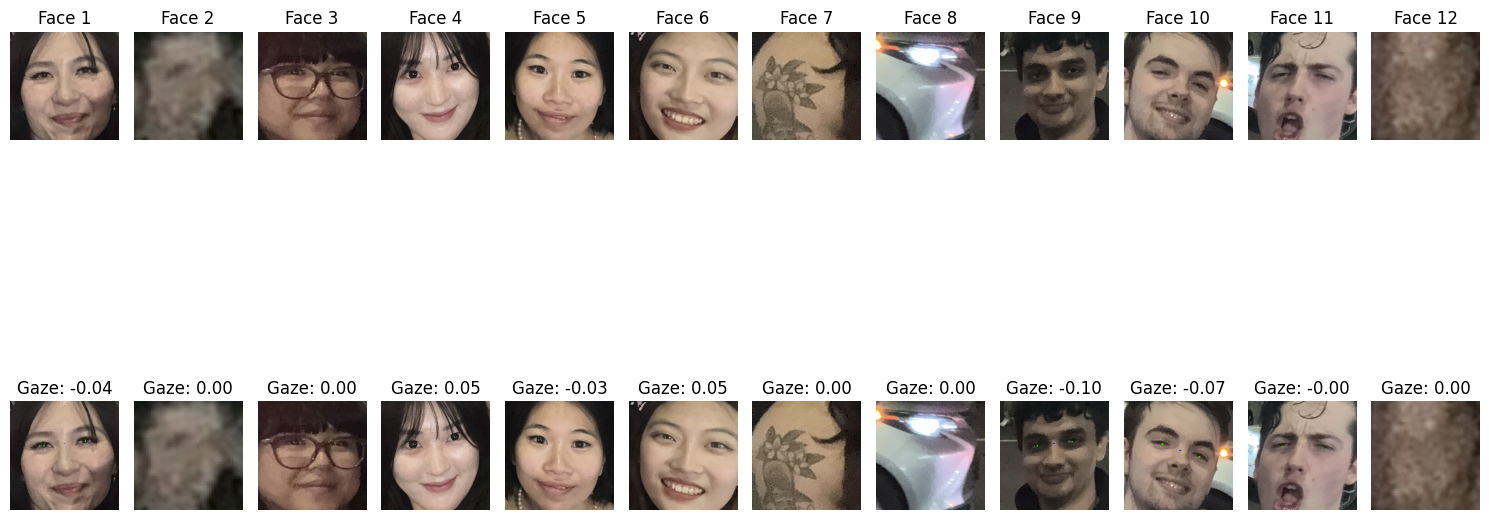

No face detected
No face detected
No face detected
No face detected
No face detected


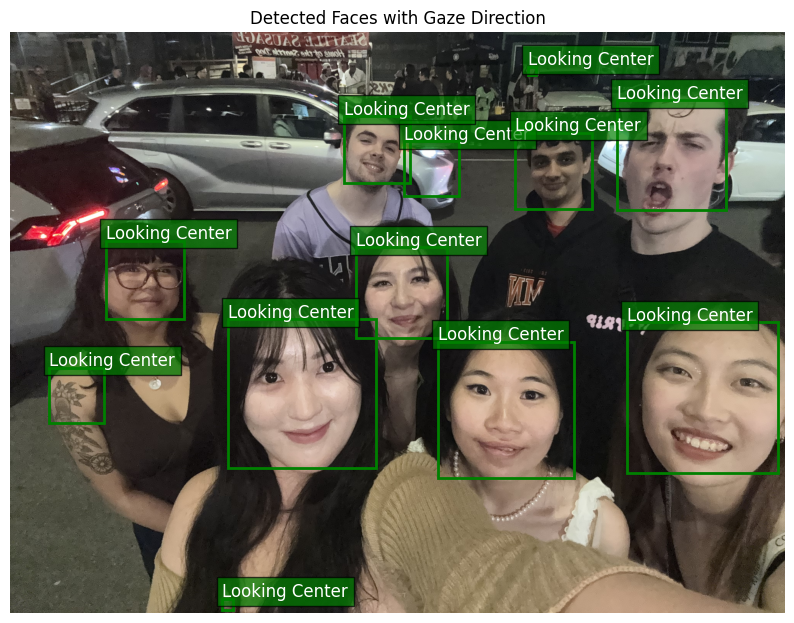

In [11]:
# Import our face detector
# from src.face_utils import detect_faces

#############
# Fix the above line when putting files in final repo
###
# Just define the function directly in your notebook for simplicity
def detect_faces(image_path):
    """Detect faces in an image and return face images and their boxes"""
    import cv2
    import numpy as np
    
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Couldn't read image from {image_path}")
        return [], [], None
    
    # Convert to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load the face detector - using a simple OpenCV one
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Detect faces
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces_rect = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    
    # Process results
    faces = []
    boxes = []
    
    for (x, y, w, h) in faces_rect:
        face_img = image_rgb[y:y+h, x:x+w]
        faces.append(face_img)
        boxes.append([x, y, x+w, y+h])
    
    return faces, boxes, image_rgb





# Test on a sample image
def test_gaze_detection(image_path):
    """Test gaze detection on a face image"""
    
    # Detect faces
    faces, boxes, image = detect_faces(image_path)
    
    if len(faces) == 0:
        print("No faces detected!")
        return
    
    plt.figure(figsize=(15, 10))
    
    # Process each face
    for i, (face, box) in enumerate(zip(faces, boxes)):
        # Analyze gaze
        gaze_vector, face_with_gaze = analyze_gaze(face)
        
        # Display the result
        plt.subplot(2, len(faces), i + 1)
        plt.imshow(face)
        plt.title(f"Face {i+1}")
        plt.axis("off")
        
        plt.subplot(2, len(faces), i + 1 + len(faces))
        plt.imshow(face_with_gaze)
        plt.title(f"Gaze: {gaze_vector[0]:.2f}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    # Show full image with boxes
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    
    # Draw boxes and add gaze info
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        plt.gca().add_patch(
            plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                          fill=False, color='green', linewidth=2)
        )
        
        # Analyze gaze for this face
        gaze_vector, _ = analyze_gaze(faces[i])
        
        # Add text about gaze
        if gaze_vector[0] < -0.2:
            gaze_text = "Looking Left"
        elif gaze_vector[0] > 0.2:
            gaze_text = "Looking Right"
        else:
            gaze_text = "Looking Center"
            
        plt.text(x1, y1-10, gaze_text, color='white', fontsize=12,
                 bbox=dict(facecolor='green', alpha=0.7))
    
    plt.title("Detected Faces with Gaze Direction")
    plt.axis("off")
    plt.show()

# If we have a test images folder, test on one of the images
if os.path.exists('C:/Users/jaden/Documents/GitHub/TECHIN-513/finalProject3/data/test_images'):
    test_files = os.listdir('C:/Users/jaden/Documents/GitHub/TECHIN-513/finalProject3/data/test_images')
    if len(test_files) > 0:
        test_image = os.path.join('C:/Users/jaden/Documents/GitHub/TECHIN-513/finalProject3/data/test_images', test_files[0])
        test_gaze_detection(test_image)
    else:
        print("No test images found!")
else:
    print("Test images folder not found!")

## Analyzing

Creating the analysis function:

In [ ]:
def analyze_group_gaze(faces, boxes, positions):
    """
    Analyze gaze interactions between multiple people
    
    Args:
        faces: List of face images
        boxes: List of face bounding boxes
        positions: Positions of faces in the original image
        
    Returns:
        interactions: Dictionary describing gaze interactions
    """
    interactions = []
    gaze_vectors = []
    
    # Get gaze for each face
    for i, face in enumerate(faces):
        gaze_vector, _ = analyze_gaze(face)
        gaze_vectors.append(gaze_vector)
    
    # Calculate center points of each face
    face_centers = []
    for box in boxes:
        x1, y1, x2, y2 = box
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        face_centers.append((center_x, center_y))
    
    # Check if anyone is looking at someone else
    for i, gaze_vector in enumerate(gaze_vectors):
        source_center = face_centers[i]
        
        # Skip if looking straight ahead
        if abs(gaze_vector[0]) < 0.2:
            continue
        
        # Check direction
        looking_right = gaze_vector[0] > 0
        
        # For each other face, check if it's in the gaze direction
        for j, target_center in enumerate(face_centers):
            if i == j:  # Skip self
                continue
                
            # Check if target is in the right direction
            if looking_right and target_center[0] > source_center[0]:
                # Target is to the right, and person is looking right
                interactions.append({
                    'source': i,
                    'target': j,
                    'confidence': abs(gaze_vector[0])
                })
            elif not looking_right and target_center[0] < source_center[0]:
                # Target is to the left, and person is looking left
                interactions.append({
                    'source': i,
                    'target': j,
                    'confidence': abs(gaze_vector[0])
                })
    
    return interactions, gaze_vectors

## Saving functions

In [ ]:
# Save our gaze functions for use in other notebooks
with open('src/gaze_utils.py', 'w') as f:
    f.write("import cv2\n")
    f.write("import numpy as np\n")
    f.write("import dlib\n\n")
    
    # Write function definitions
    f.write(inspect.getsource(get_eyes_from_face))
    f.write("\n\n")
    f.write(inspect.getsource(estimate_gaze_direction))
    f.write("\n\n")
    f.write(inspect.getsource(analyze_gaze))
    f.write("\n\n")
    f.write(inspect.getsource(analyze_group_gaze))
    
print("Gaze detection functions saved to src/gaze_utils.py")

Ideas for future improved accuracy:
Use pupil tracking algorithms that are more robust to lighting conditions
Train a dedicated gaze estimation neural network
Include head pose estimation to factor in the face orientation
Calibrate the gaze detector for individual users